# Pathway analysis in metabolomics: Pitfalls and best practice for the use of Over-representation Analysis

Cecilia Wieder 1, Clément Frainay 3, Nathalie Poupin 3, Pablo Rodríguez-Mier 3, Florence Vinson 3, Juliette Cooke 3, Rachel Lai 2, Jake Bundy 1, Fabien Jourdan 3, Timothy Ebbels 1

1 Department of Metabolism, Digestion, and Reproduction, Faculty of Medicine, Imperial College London, London SW7 2AZ, UK

2 Department of Infectious Disease, Faculty of Medicine, Imperial College London, London SW7 2AZ, UK

3 INRA, Toulouse University, INP, UMR 1331, Toxalim, Research Centre in Food Toxicology, 180 chemin de Tournefeuille, Toulouse, France


#### This notebook contains the code to run the following simulations:
- <a href='#s1'>Background list</a>
- <a href='#s2'>DA metabolite list size</a>
- <a href='#s3'>General vs. organism-specific pathway set</a>
- <a href='#s4'>Pathway database choice</a>
- <a href='#s5'>Metabolite misidentification</a>
- <a href='#s6'>Metabolite polarity</a>

#### The following scripts are required to run the code in this notebook. They should be saved in the same folder as this notebook. 
- process_datasets.py: Pre-processing of abundance matrices for the required datasets. 
- utils.py: Utilities for t-tests, ORA, and simulations.

All packages required are listed in the requirements.txt file. All simulations have been tested using Python version 3.8. Please note, some cells will take several minutes to run depending on the number of permutations the simulation is repeated for. 

In [ ]:
# install the required packages
pip install -r requirements.txt 

In [4]:
from src import utils
from src import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import os

FileNotFoundError: [Errno 2] No such file or directory: '../data/MetaCyc_compound_mapping.pickle'

In [2]:
# Import the relevant datasets
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import pathway sets
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
KEGG_compounds_masses = pd.read_csv("KEGG_compounds_masses_estimated.csv", names=["compound", "formula", "mass"])

# param grid
datasets = {"Labbé": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg, mat_brown,
                      [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Yachida": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg, mat_yamada,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg, mat_stevens,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Quirós": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg, mat_auwerx,
                       [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)], KEGG_compounds_masses],
            "Fuhrer (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg, mat_yfgM,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses],
            "Fuhrer (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg, mat_dcuS,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses]}

print("Processing complete.")

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Processing complete.


<a id='s1'></a>
## Background list

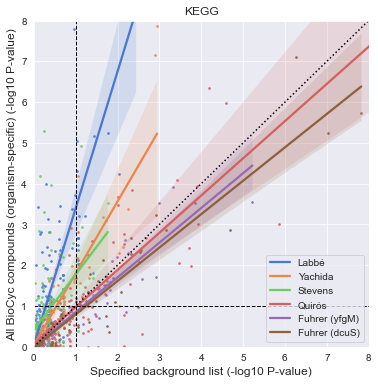

In [5]:
def plot_log_pvalues(db="KEGG"):
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    plt_dict = {}
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        ora_res_pvals = np.negative(np.log10(ora_res["P-value"].tolist()))
        ora_res_all_pvals = np.negative(np.log10(ora_res_all["P-value"].tolist()))
        plt_dict[i] = [ora_res_pvals, ora_res_all_pvals]

    plt.figure(figsize=(6, 6))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        # jittered_y = y + 0.1 * np.random.rand(len(y)) - 0.05
        # jittered_x = x + 0.1 * np.random.rand(len(x)) - 0.05
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         scatter_kws={'s': 3})
    ax.set_xlabel("Specified background list (-log10 P-value)",
                  fontsize=12)
    ax.set_ylabel("All BioCyc compounds (organism-specific) (-log10 P-value)",
                  fontsize=12)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG")
#     plt.savefig("../Figures/logp_plot_BioCyc.png", dpi=300)
    plt.show()
plot_log_pvalues(db="KEGG")

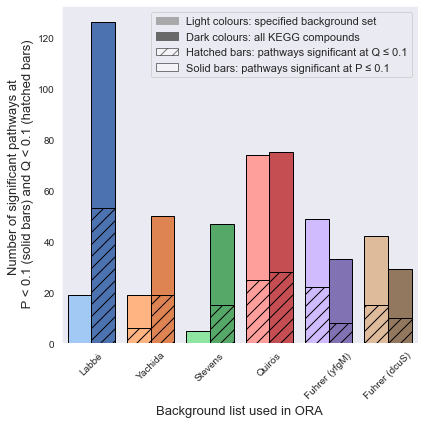

In [13]:
def plot_grouped_stacked_bar(db="KEGG"):
    dataframes = []
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    if db == "Cyc":
        d_sets = datasets_biocyc
    for i in d_sets.keys():
        ora_res = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_all = utils.over_representation_analysis(d_sets[i][0], d_sets[i][3], d_sets[i][2])
        intersect = (set(ora_res["Pathway_ID"].tolist()) & set(ora_res_all["Pathway_ID"].tolist()))
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_all = ora_res_all[ora_res_all["Pathway_ID"].isin(intersect)]
        n_p_less_01 = len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01 = len(ora_res[ora_res["P-adjust"] < 0.1]["P-adjust"].tolist())
        n_p_less_01_all = len(ora_res_all[ora_res_all["P-value"] < 0.1]["P-value"].tolist())
        n_q_less_01_all = len(ora_res_all[ora_res_all["P-adjust"] < 0.1]["P-adjust"].tolist())
        df = pd.DataFrame([[n_q_less_01, n_p_less_01], [n_q_less_01_all, n_p_less_01_all]],
                          index=["Specified background list", "All " + db + " compounds"], columns=["P", "Q"])
        df["Name"] = i
        dataframes.append(df)

    dfall = pd.concat([pd.melt(i.reset_index(),
                               id_vars=["Name", "index"])  # transform in tidy format each df
                       for i in dataframes],
                      ignore_index=True)

    dfall.set_index(["Name", "index", "variable"], inplace=True)
    dfall["vcs"] = dfall.groupby(level=["Name", "index"]).cumsum()
    dfall.reset_index(inplace=True)
    sns.set_style("dark")
    sns.set_palette("muted")
    plt.figure(figsize=(6, 6))
    for i, g in enumerate(dfall.groupby("variable")):
        ax = sns.barplot(data=g[1],
                         x="Name",
                         y="vcs",
                         hue="index",
                         zorder=-i,  # so first bars stay on top
                         edgecolor="k",
                         ci=None)
    ax.set_xlabel('Background list used in ORA', fontsize=13)
    # ax.set_xticks(x, labels, rotation='vertical')
    ax.set_ylabel('Number of significant pathways at \n P < 0.1 (solid bars) and Q < 0.1 (hatched bars)', fontsize=13)
    # labels = ["Quirós", "Yachida", "Stevens", "Labbé", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]

    # Set hatches for q-values bars
    # plt.subplots_adjust(right=0.8)
    plt.xticks(rotation=45)
    bars = ax.patches
    for i in range(6, 12):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 6])
        bars[i].set_edgecolor("k")
    for i in range(0, 6):
        bars[i].set_color(sns.color_palette("pastel", 6)[i])
        bars[i].set_edgecolor("k")
    for i in range(12, 18):
        bars[i].set_color(sns.color_palette("pastel", 6)[i - 12])
        bars[i].set_edgecolor("k")
    for i in range(18, 24):
        bars[i].set_color(sns.color_palette("deep", 6)[i - 18])
        bars[i].set_edgecolor("k")
    for i in range(0, 12, 1):
        bars[i].set_hatch('//')

    specified_patch = mpatches.Patch(color='darkgray', label='Light colours: specified background set')
    unspecified_patch = mpatches.Patch(color='dimgray', label='Dark colours: all KEGG compounds')
    hatched = mpatches.Patch(facecolor='white', hatch="//", label='Hatched bars: pathways significant at Q ≤ 0.1',
                             edgecolor='k', alpha=0.5)
    solid = mpatches.Patch(facecolor='white', label='Solid bars: pathways significant at P ≤ 0.1', edgecolor='k',
                           alpha=0.5)
    plt.legend(handles=[specified_patch, unspecified_patch, hatched, solid], fontsize=11)

    # plt.title(db, fontsize=14)
    plt.tight_layout()
    # plt.savefig("../Figures/all_vs_experimental_barchart_KEGG.png", dpi=600)
    plt.show()

plot_grouped_stacked_bar(db="KEGG")

### Background list size reduction

Labbé
Yachida
Stevens
Quirós
Fuhrer (yfgM)
Fuhrer (dcuS)


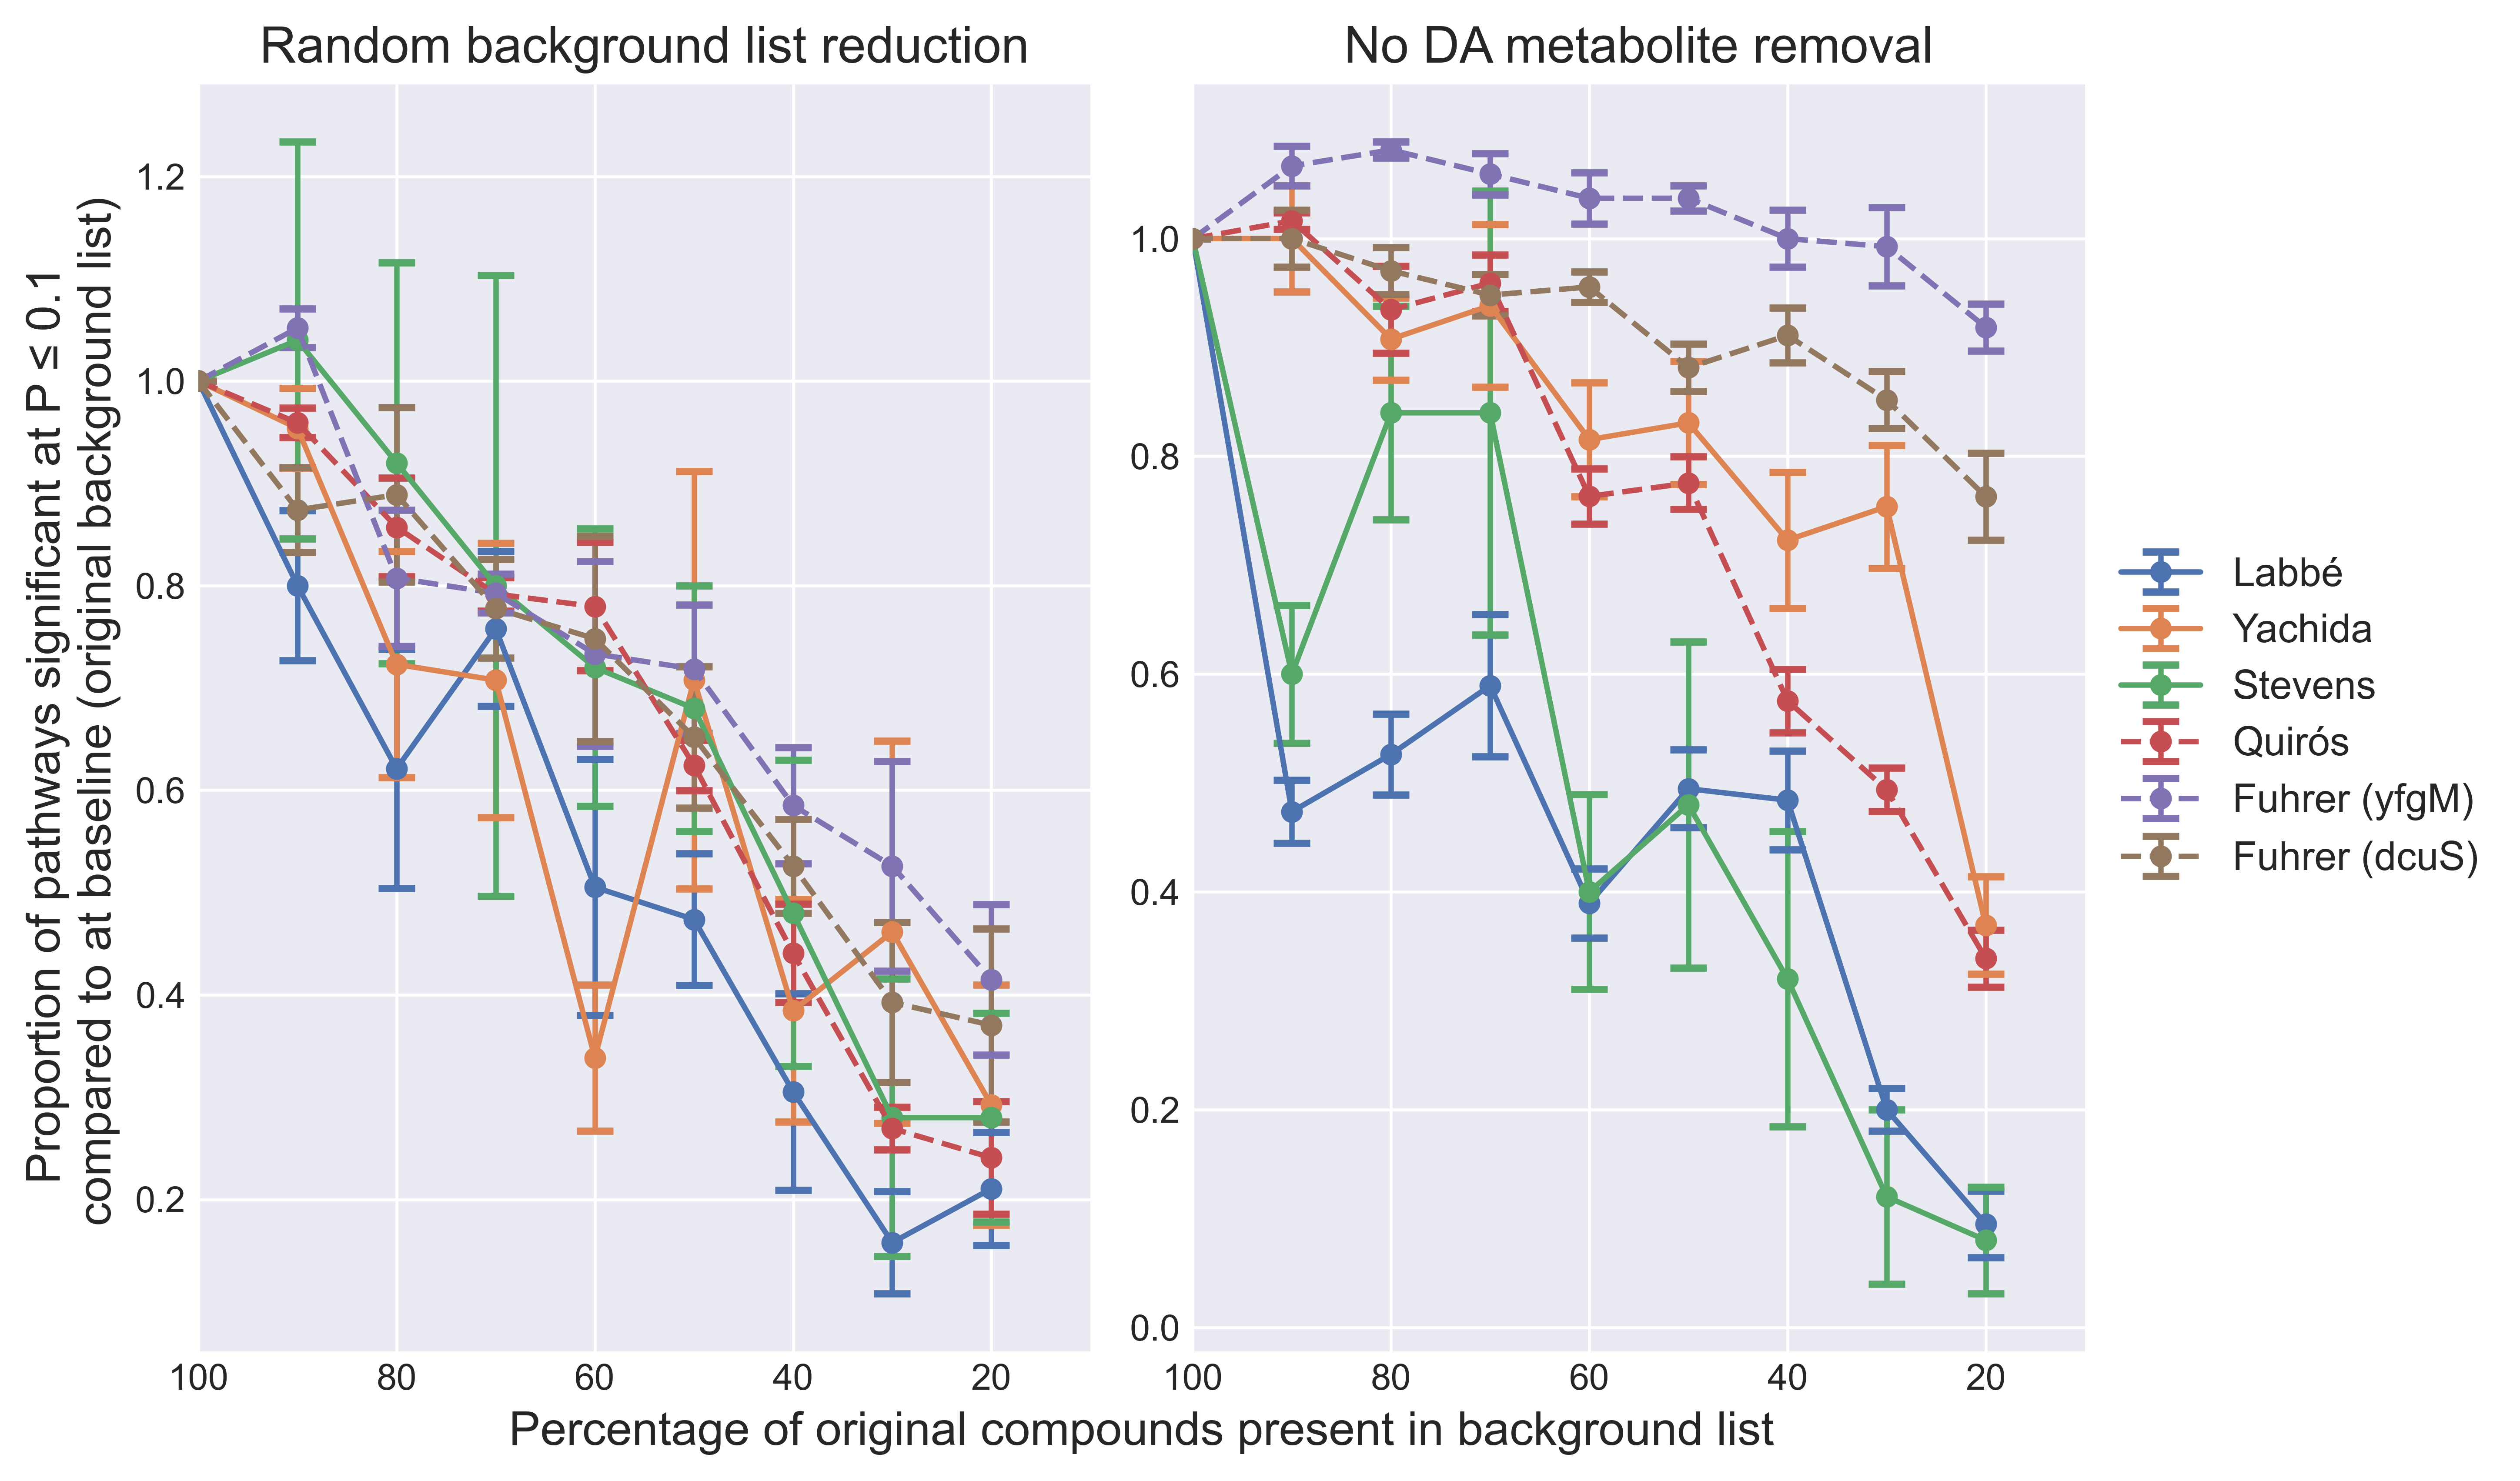

In [8]:
np.seterr(all="ignore")
def reduce_background_set(db="KEGG"):
    percentage_reductions_keep_DEM = [i for i in range(100, 10, -10)]
    percentage_reductions = [i for i in range(100, 10, -10)]
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_lists_keep_DEM = []
    results_lists = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Fuhrer"):
            for i in percentage_reductions:
                res = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0], d_sets[d][2],
                                                       nsim=5, keep_DEM=False, Zamboni=True)
                results_lists.append([d, i] + res)
            for i in percentage_reductions_keep_DEM:
                res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0],
                                                                d_sets[d][2], nsim=5, keep_DEM=True, Zamboni=True)
                results_lists_keep_DEM.append([d, i] + res_keep_DEM)
        else:
            for i in percentage_reductions:
                res = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0], d_sets[d][2],
                                                       nsim=5, keep_DEM=False, Zamboni=False)
                results_lists.append([d, i] + res)
            for i in percentage_reductions_keep_DEM:
                res_keep_DEM = utils.reduce_background_list_ora(d_sets[d][1], d_sets[d][4], i, d_sets[d][0],
                                                                d_sets[d][2], nsim=5, keep_DEM=True, Zamboni=False)
                results_lists_keep_DEM.append([d, i] + res_keep_DEM)

    res_df = pd.DataFrame(results_lists,
                          columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                   "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                   "q_std", "sd_proportion_p_vals"])
    res_df_keep_DEM = pd.DataFrame(results_lists_keep_DEM,
                                   columns=["Dataset", "Percentage reduction", "n_p_less_0.1",
                                            "n_q_less_0.1", "mean_proportion_p_vals", "p_std",
                                            "q_std", "sd_proportion_p_vals"])

    simulation_res = res_df
    simulation_res_keep_DEM = res_df_keep_DEM
    with plt.style.context('seaborn-darkgrid'):
        sns.set_palette("deep")
        fig = plt.figure(figsize=(10, 6), dpi=600)
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax1.set_title("Random background list reduction", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax1.errorbar(simulation_res[simulation_res["Dataset"] == i]['Percentage reduction'],
                             simulation_res[simulation_res["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res[simulation_res["Dataset"] == i]['sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax1.set_xlim(100, 10)
        ax2.set_title("No DA metabolite removal", fontsize=14)
        for i in d_sets.keys():
            if i in ["Quirós", "Fuhrer (yfgM)", "Fuhrer (dcuS)"]:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="--", capsize=5, markeredgewidth=2, markersize=4)
            else:
                ax2.errorbar(simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['Percentage reduction'],
                             simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i]['mean_proportion_p_vals'],
                             yerr=simulation_res_keep_DEM[simulation_res_keep_DEM["Dataset"] == i][
                                 'sd_proportion_p_vals'],
                             label=i, fmt='o', linestyle="solid", capsize=5, markeredgewidth=2, markersize=4)
        ax2.set_xlim(100, 10)
        handles, labels = ax1.get_legend_handles_labels()
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.grid(False)

        plt.ylabel("Proportion of pathways significant at P ≤ 0.1 \n compared to at baseline (original background list)",
                   fontsize=13)
        plt.xlabel("Percentage of original compounds present in background list", fontsize=13)
        plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
        plt.tight_layout()
#         plt.savefig("background_list_reduction_proportion_KEGG_new2.png", dpi=600)
        plt.show()

reduce_background_set(db="KEGG")

<a id='s2'></a>
## List of input metabolites

Labbé
269
       0   1   2      3           4
0  0.005  46   9  Labbé  bonferroni
2  0.050  58  12  Labbé  bonferroni
4  0.100  66  12  Labbé  bonferroni


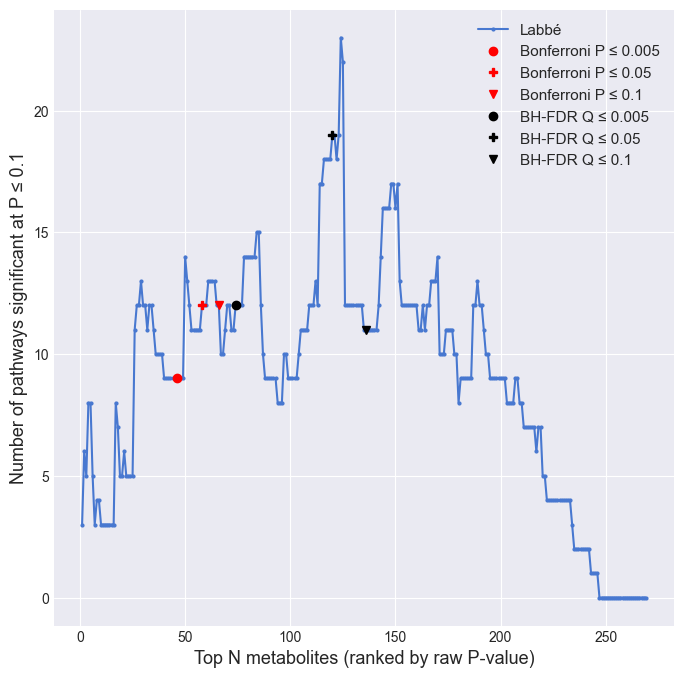

In [79]:
import matplotlib

def vary_dam_size_single_rankbyp(dataset):
    multiple_test_options = ["bonferroni", "fdr_bh"]
    res_list = []
    for d in [dataset]:
        if d.startswith("Fuhrer"):
            p_vals_dict = {}
            for x in datasets[d][4].T.itertuples():
                zscore = x[1]
                pval = stats.norm.cdf(zscore)
                p_vals_dict[x[0]] = pval
            pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
            padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
            pvals_df["P-adjust"] = padj
            pvals_df["ranked_padj"] = stats.rankdata(pvals_df["P-adjust"], method='min')
            pvals_df = pvals_df.sort_values(by="ranked_padj")

            max_rank = pvals_df["ranked_padj"].max()
            for i in range(1, len(pvals_df["P-adjust"]) + 1):
                metabolite_rank = pvals_df.iloc[i - 1, 2]
                DA_metabolites = pvals_df[pvals_df["ranked_padj"] <= metabolite_rank].index.tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, m, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

        else:
            t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
            t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
            t_test_res = t_test_res.sort_values(by="ranked_p")
            # t_test_res.to_csv("Labbe_ttest_res" + m + ".csv")

            max_rank = t_test_res["ranked_p"].max()
            for i in range(1, len(t_test_res["Metabolite"]) + 1):
                metabolite_rank = t_test_res.iloc[i - 1, 3]
#                 print("Metabolite:", i, "rank:", metabolite_rank)
                DA_metabolites = t_test_res[t_test_res["ranked_p"] <= metabolite_rank]["Metabolite"].tolist()
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_list.append([d, i, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])

    res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

    # add annotations
    cutoffs = [0.005, 0.05, 0.1]
    annotations = []
    for d in [dataset]:
        for c in cutoffs:
            for m in multiple_test_options:
                if d.startswith("Fuhrer"):
                    p_vals_dict = {}
                    for x in datasets[d][4].T.itertuples():
                        zscore = x[1]
                        pval = stats.norm.cdf(zscore)
                        p_vals_dict[x[0]] = pval
                    pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                    padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                    pvals_df["P-adjust"] = padj
                    DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                    percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, percentage,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
                else:
                    t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                    DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                    n_DA = len(DA_metabolites)
                    ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                    res_df.loc[len(res_df), :] = [d, n_DA,
                                                  len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                    annotations.append(
                        [c, n_DA, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])

    cutoffs_df = pd.DataFrame(annotations)
    cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
    cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]
    res_df = res_df.sort_values(by='Cutoff_P')

    with plt.style.context('seaborn-darkgrid'):
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
        cols = sns.color_palette("muted", 8)
        for num, i in enumerate([dataset]):
            ax1.plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                     res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                     label=i, linestyle='-', color=cols[num], markersize=2)
            
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.005][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.005][2].tolist(), 'o',
                     label="Bonferroni P ≤ 0.005", linestyle="None", color="red", markersize=6)
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.05][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.05][2].tolist(), 'P',
                     label="Bonferroni P ≤ 0.05", linestyle="None", color="red", markersize=6)
            ax1.plot(cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.1][1].to_list(),
                     cutoffs_bonferroni[cutoffs_bonferroni[0] == 0.1][2].tolist(), 'v',
                     label="Bonferroni P ≤ 0.1", linestyle="None", color="red", markersize=6)
            
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.005][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.005][2].tolist(), 'o',
                     label="BH-FDR Q ≤ 0.005", linestyle="None", color="black", markersize=6)
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.05][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.05][2].tolist(), 'P',
                     label="BH-FDR Q ≤ 0.05", linestyle="None", color="black", markersize=6)
            ax1.plot(cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.1][1].to_list(),
                     cutoffs_FDR_BH[cutoffs_FDR_BH[0] == 0.1][2].tolist(), 'v',
                     label="BH-FDR Q ≤ 0.1", linestyle="None", color="black", markersize=6)

        plt.legend(fontsize=11)
        ax1.set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
        ax1.set_xlabel("Top N metabolites (ranked by raw P-value)", fontsize=13)

#         plt.savefig("../Figures/vary_input_metabolites_Labbe2.png", dpi=600)
        plt.show()


vary_dam_size_single_rankbyp("Labbé")


Labbé
Yachida
Stevens
Quirós
Fuhrer (yfgM)
Fuhrer (dcuS)


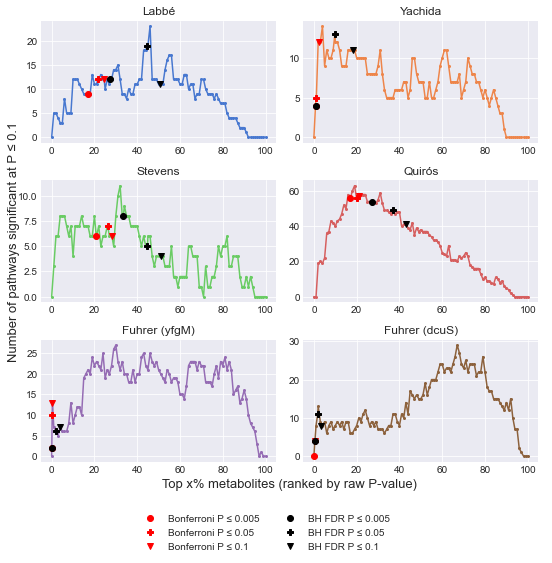

In [7]:
datasets = {"Labbé": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg, mat_brown,
                      [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Yachida": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg, mat_yamada,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg, mat_stevens,
                        [i for i in range(0, 40, 5)], [i for i in range(0, 35, 5)], KEGG_compounds_masses],
            "Quirós": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg, mat_auwerx,
                       [i for i in range(0, 14, 1)], [i for i in range(0, 12, 1)], KEGG_compounds_masses],
            "Fuhrer (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg, mat_yfgM,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses],
            "Fuhrer (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg, mat_dcuS,
                              [i for i in range(0, 7, 1)], [i for i in range(0, 6, 1)], KEGG_compounds_masses]}

import matplotlib

proportion_of_bg = [i for i in range(1, 101, 1)]
multiple_test_options = ["bonferroni", "fdr_bh"]
res_list = []
for d in datasets.keys():
    res_list.append([d, 0, 0])
    print(d)
    for p in proportion_of_bg:
        if d.startswith("Fuhrer"):
            p_vals_dict = {}
            for x in datasets[d][4].T.itertuples():
                zscore = x[1]
                pval = stats.norm.cdf(zscore)
                p_vals_dict[x[0]] = pval
            pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
            padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method="fdr_bh")[1]
            pvals_df["P-adjust"] = padj
            pvals_df["ranked_p"] = stats.rankdata(pvals_df["P-value"], method='min')
            pvals_df = pvals_df.sort_values(by="ranked_p")
            select_up_to = int((len(pvals_df["P-value"]) - 1) * (p / 100))
            selected_rank = pvals_df.iloc[select_up_to, 2]
            DA_metabolites = pvals_df[pvals_df["ranked_p"] <= selected_rank].index.tolist()
            ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
            res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
        else:
            t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], "fdr_bh")
            t_test_res["ranked_p"] = stats.rankdata(t_test_res["P-value"], method='min')
            t_test_res = t_test_res.sort_values(by="ranked_p")
            select_up_to = int((len(t_test_res["Metabolite"]) - 1) * (p / 100))
            selected_rank = t_test_res.iloc[select_up_to, 3]
            DA_metabolites = t_test_res[t_test_res["ranked_p"] <= selected_rank]["Metabolite"].tolist()
            ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
            res_list.append([d, p, len(ora_res[ora_res["P-value"] < 0.1]["P-value"].tolist())])
res_df = pd.DataFrame(res_list, columns=["Dataset", "Cutoff_P", "n_p_less_01"])

# add annotations
cutoffs = [0.005, 0.05, 0.1]
annotations = []
for d in datasets.keys():
    for c in cutoffs:
        for m in multiple_test_options:
            if d.startswith("Fuhrer"):
                p_vals_dict = {}
                for x in datasets[d][4].T.itertuples():
                    zscore = x[1]
                    pval = stats.norm.cdf(zscore)
                    p_vals_dict[x[0]] = pval
                pvals_df = pd.DataFrame.from_dict(p_vals_dict, orient='index', columns=["P-value"])
                padj = sm.stats.multipletests(pvals_df["P-value"], 0.05, method=m)[1]
                pvals_df["P-adjust"] = padj
                DA_metabolites = pvals_df[pvals_df["P-adjust"] <= c].index.tolist()
                percentage = (len(DA_metabolites) / len(datasets[d][1])) * 100
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_df.loc[len(res_df), :] = [d, percentage,
                                              len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                annotations.append(
                    [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])
            else:
                t_test_res = utils.t_tests(datasets[d][4].iloc[:, :-1], datasets[d][4]["Group"], m)
                DA_metabolites = t_test_res[t_test_res["P-adjust"] <= c]["Metabolite"].tolist()
                percentage = (len(DA_metabolites) / len(t_test_res["Metabolite"])) * 100
                ora_res = utils.over_representation_analysis(DA_metabolites, datasets[d][1], datasets[d][2])
                res_df.loc[len(res_df), :] = [d, percentage,
                                              len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist())]

                annotations.append(
                    [c, percentage, len(ora_res[ora_res["P-value"] <= 0.1]["P-value"].tolist()), d, m])


cutoffs_df = pd.DataFrame(annotations)
cutoffs_bonferroni = cutoffs_df[cutoffs_df[4] == "bonferroni"]
cutoffs_FDR_BH = cutoffs_df[cutoffs_df[4] == "fdr_bh"]
res_df = res_df.sort_values(by='Cutoff_P')

with plt.style.context('seaborn-darkgrid'):
    fig, axs = plt.subplots(3,2, figsize=(8, 8))
    axs = axs.ravel()
    cols = sns.color_palette("muted", 8)
    for num, i in enumerate(datasets):
        cutoffs_bonferroni_dset = cutoffs_bonferroni[cutoffs_bonferroni[3] == i]
        cutoffs_FDR_BH_dset = cutoffs_FDR_BH[cutoffs_FDR_BH[3] == i]
        axs[num].plot(res_df[res_df["Dataset"] == i]['Cutoff_P'].to_list(),
                 res_df[res_df["Dataset"] == i]['n_p_less_01'].tolist(), 'o',
                 label=i, linestyle='-', color=cols[num], markersize=2)
        axs[num].set_title(i)

        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.005][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.005][2].tolist(), 'o',
                 label="Bonferroni P ≤ 0.005", linestyle="None", color="red", markersize=6)
        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.05][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.05][2].tolist(), 'P',
                 label="Bonferroni P ≤ 0.05", linestyle="None", color="red", markersize=6)
        axs[num].plot(cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.1][1].to_list(),
                 cutoffs_bonferroni_dset[cutoffs_bonferroni_dset[0] == 0.1][2].tolist(), 'v',
                 label="Bonferroni P ≤ 0.1", linestyle="None", color="red", markersize=6)

        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.005][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.005][2].tolist(), 'o',
                 label="BH-FDR Q ≤ 0.005", linestyle="None", color="black", markersize=6)
        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.05][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.05][2].tolist(), 'P',
                 label="BH-FDR Q ≤ 0.05", linestyle="None", color="black", markersize=6)
        axs[num].plot(cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.1][1].to_list(),
                 cutoffs_FDR_BH_dset[cutoffs_FDR_BH_dset[0] == 0.1][2].tolist(), 'v',
                 label="BH-FDR Q ≤ 0.1", linestyle="None", color="black", markersize=6)


#             axs[num].set_ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
#             axs[num].set_xlabel("Top N metabolites (ranked by raw P-value)", fontsize=13)
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Top x% metabolites (ranked by raw P-value)", fontsize=13)
    plt.ylabel("Number of pathways significant at P ≤ 0.1", fontsize=13)
    from matplotlib.lines import Line2D
    linestyles = ['o', 'P', 'v']
    lines = [Line2D([0], [0], color='red', linewidth=3, marker=l, linestyle="None") for l in linestyles]
    lines2 = [Line2D([0], [0], color='black', linewidth=3, marker=l, linestyle="None") for l in linestyles]
    lines = lines + lines2
    labels = ['Bonferroni P ≤ 0.005', 'Bonferroni P ≤ 0.05', 'Bonferroni P ≤ 0.1', 'BH FDR P ≤ 0.005', 'BH FDR P ≤ 0.05', 'BH FDR P ≤ 0.1']
    fig.subplots_adjust(bottom=0.3, wspace=0.33)

    plt.legend(lines, labels, fancybox=True, loc='upper center', 
             bbox_to_anchor=(0.45, -0.1), ncol=2)
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()
    plt.savefig("../Figures/vary_input_metabolites_2.png", dpi=600)
    plt.show()



<a id='s3'></a>
## General vs. organism-specific pathway set

         Dataset  Common pathways  Organism-specific only  Reference only
0          Labbé               19                       0               6
1        Yachida               12                       1              17
2        Stevens                5                       0               1
3         Quirós               46                       3              28
4  Fuhrer (yfgM)               27                       0              26
5  Fuhrer (dcuS)               27                       0              23


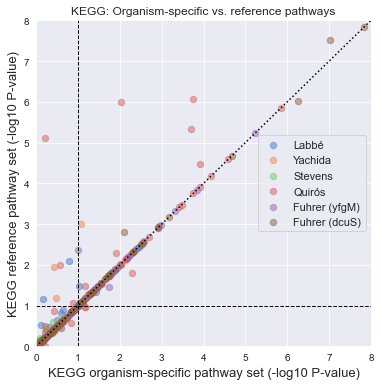

In [3]:
KEGG_reference_pathways = pd.read_csv("KEGG_reference_pathways_compounds.csv", dtype=str, index_col=0)

def organism_vs_reference(db="KEGG"):
    d_sets = datasets

    plt_dict = {}
    res_lists = []
    for i in d_sets.keys():
        ora_res_org = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], d_sets[i][2])
        ora_res_ref = utils.over_representation_analysis(d_sets[i][0], d_sets[i][1], KEGG_reference_pathways)
        intersect = (set(ora_res_org["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref["Pathway_ID"].str.slice(start=-5).tolist()))
        common = set(set(ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist()) & set(ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist()))
        org_only = np.setdiff1d(ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist(),
                                ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist())
        ref_only = np.setdiff1d(ora_res_ref[ora_res_ref["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist(),
                                ora_res_org[ora_res_org["P-value"] <= 0.1]["Pathway_ID"].str.slice(start=-5).tolist())
        res_lists.append([i, len(common), len(org_only), len(ref_only)])
        # Ensures pathways are the same in both results (whole background can have additional pathways)
        ora_res_ref = ora_res_ref[ora_res_ref["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org = ora_res_org[ora_res_org["Pathway_ID"].str.slice(start=-5).isin(intersect)]
        ora_res_org_pvals = np.negative(np.log10(ora_res_org["P-value"].tolist()))
        ora_res_ref_pvals = np.negative(np.log10(ora_res_ref["P-value"].tolist()))
        plt_dict[i] = [ora_res_org_pvals, ora_res_ref_pvals]

    results_table = pd.DataFrame(res_lists, columns=["Dataset", "Common pathways", "Organism-specific only", "Reference only"])
    print(results_table)

    plt.figure(figsize=(6, 6))
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    for i in plt_dict.keys():
        x = plt_dict[i][0]
        y = plt_dict[i][1]
        ax = sns.regplot(x=x, y=y,
                         ci=95,
                         fit_reg=False,
                         scatter_kws={'s': 40, 'alpha': 0.5, 'linestyle': 'None'})
    # ax.lines[3].set_linestyle("--")
    # ax.lines[4].set_linestyle("--")
    # ax.lines[5].set_linestyle("--")
    ax.set_xlabel("KEGG organism-specific pathway set (-log10 P-value)",
                  fontsize=13)
    ax.set_ylabel("KEGG reference pathway set (-log10 P-value)",
                  fontsize=13)
    ax.set(ylim=(0, 8), xlim=(0, 8))
    ax.legend(plt_dict.keys(), fontsize=11)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle=':')
    ax.axhline(y=1, linewidth=1, color='black', linestyle='--')
    ax.axvline(x=1, linewidth=1, color='black', linestyle='--')
    plt.title("KEGG: Organism-specific vs. reference pathways")
    plt.show()

organism_vs_reference()

#### Calculate average pathway size

In [2]:
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [15]:
ref_paths = process_paths(KEGG_reference_pathways)
human_paths = process_paths(KEGG_human_pathways)
avg_ref_pathway_size = np.mean([len(v) for k, v in ref_paths.items()])
avg_hum_pathway_size = np.mean([len(v) for k, v in human_paths.items()])
# mouse_pathway_size = 
# eco_pathway_size = 
print("Average reference pathway size:", avg_ref_pathway_size)
print("Average human pathway size:", avg_hum_pathway_size)
print("Total reference pathways:", len(ref_paths))
print("Total human pathways:", len(human_paths))

Average reference pathway size: 44.88859416445624
Average human pathway size: 29.582375478927204
Total reference pathways: 377
Total human pathways: 261


#### Calculate Jaccard index for common pathways

In [13]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [31]:
common_paths_ref_human = list(set([i[3:] for i in ref_paths.keys()]) & set([i[3:] for i in human_paths.keys()]))

jaccard_indexes_human_ref = []
for pathway_id in common_paths_ref_human:
    jaccard_index = jaccard_similarity(ref_paths["map"+str(pathway_id)], human_paths["hsa"+str(pathway_id)])
    jaccard_indexes_human_ref.append(jaccard_index)
    
print("Average Jaccard index for common reference and human pathways:", np.mean(jaccard_indexes_human_ref))

Average Jaccard index for common reference and human pathways: 0.7489924529127291


<a id='s4'></a>
## Pathway database choice

### Database size comparison

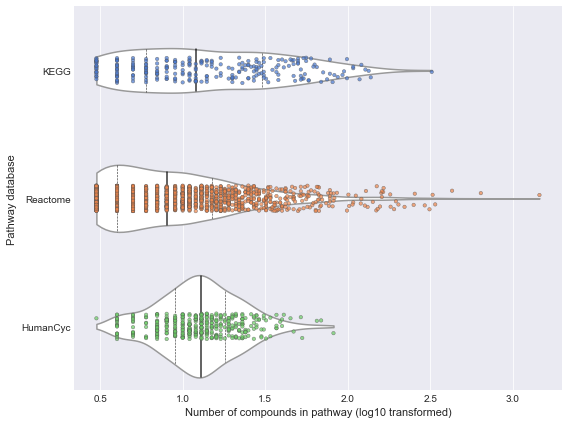

In [4]:
KEGG_pathway_df = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]
Metacyc_human_pathways = pd.read_csv("Metacyc_human_pathways.csv", dtype=str, index_col=0)

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)
metacyc_pathway_dict = process_paths(Metacyc_human_pathways)

pathway_length_KEGG = [np.log10(len(v)) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [np.log10(len(v)) for k, v in Reactome_pathway_dict.items()]
pathway_length_metacyc = [np.log10(len(v)) for k, v in metacyc_pathway_dict.items()]

df = pd.DataFrame([pathway_length_KEGG, pathway_length_Reactome, pathway_length_metacyc]).T
df.columns = ["KEGG", "Reactome", "HumanCyc"]
df = df.melt(var_name='groups', value_name='vals')
plt.style.use("seaborn-darkgrid")
fig, ax1 = plt.subplots(figsize=(8,6))

ax = sns.violinplot(x=df.vals, y=df.groups, color="white", inner="quartile", edgecolor="k", cut=0)
ax = sns.stripplot(x=df.vals, y=df.groups, size=3.5, linewidth=0.5, alpha=0.7)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(0.6)
    l.set_color('black')
    l.set_alpha(0.8)
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    l.set_alpha(0.8)

plt.ylabel("Pathway database", fontsize=11)
plt.xlabel("Number of compounds in pathway (log10 transformed)", fontsize=11)
plt.tight_layout()
plt.show()

### Pathway database updates -  Reactome (release 60-75)
Reactome has 4 major releases per year. 

In [2]:
def process_reactome_file(fname):
    infile = pd.read_csv(fname, sep="\t", header=None)
    infile = infile.astype(str)
    name_dict = dict(zip(infile[1], infile[3]))

    groups = infile.groupby([1])[0].apply(list).to_dict()
    df = pd.DataFrame.from_dict(groups, orient='index')
    pathway_ids = df.index.tolist()

    df['Pathway_name'] = df.index.map(name_dict)
    col = df.pop("Pathway_name")
    df.insert(0, "Pathway_name", col)
    return df

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "None"]
        
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

In [ ]:
reactome_pathway_sets = []

directory = r"Old_Reactome_All_Levels"
for filename in os.listdir(directory):
    if filename.startswith("ChEBI2Reactome"):
        processed_df = process_reactome_file("Old_Reactome_All_Levels/"+filename)
        Reactome_human_pathways = processed_df[processed_df.index.str.contains("HSA")]
        reactome_pathway_sets.append({filename[-6:-4] : Reactome_human_pathways})


In [14]:
Reactome_pathway_dicts = {}
for i in reactome_pathway_sets:
    for k, v in i.items():

        reactome_dict = process_paths(v)
        Reactome_pathway_dicts.update({k: reactome_dict})
        
releases = sorted(Reactome_pathway_dicts.keys())
print(releases)
pathway_stats = pd.DataFrame(index=releases, columns=["Number of pathways", "Number of unique compounds", "Mean pathway size"])
for release in pathway_stats.index:
    pathway_stats.loc[release, "Number of pathways"] = len(Reactome_pathway_dicts[release])
    pathway_stats.loc[release, "Number of unique compounds"] = len(set([item for sublist in Reactome_pathway_dicts[release].values() for item in sublist]))
    pathway_stats.loc[release, "Mean pathway size"] = np.mean([len(i) for i in Reactome_pathway_dicts[release].values()])

In [28]:
pathway_stats

,Number of pathways,Number of unique compounds,Mean pathway size
61,1327,2967,17.464205
62,1325,2963,17.216604
63,1326,2960,17.259427
64,1354,3101,17.650665
65,1360,3121,17.527941
66,1374,3199,17.653566
68,1382,3287,18.070188
69,1390,3293,17.908633
70,1397,3395,17.850394
71,1490,3499,17.539597


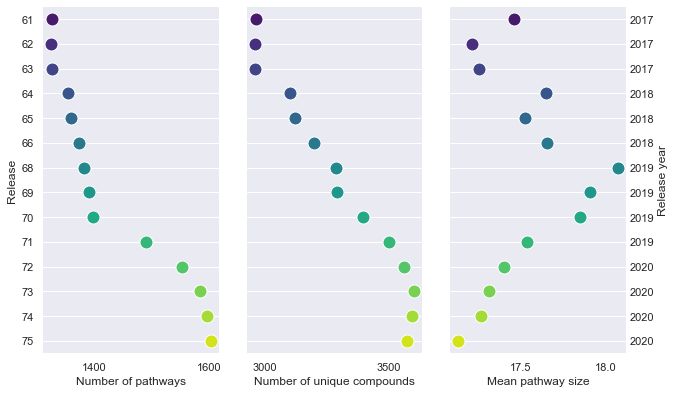

In [62]:
sns.set_style("darkgrid")
pathway_stats["Release"] = pathway_stats.index
pathway_stats["Year"] = ["2017", "2017", "2017","2018", "2018", "2018","2019", "2019", "2019", "2019", "2020", "2020", "2020", "2020"]
g = sns.PairGrid(pathway_stats.sort_values('Release', ascending=True),
                 x_vars = pathway_stats.columns[0:3], y_vars='Release', height=6, aspect=.55)



# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=13, orient="h", jitter=False,
      palette="viridis", linewidth=1, edgecolor="w")

# Use semantically meaningful titles for the columns
titles = ["a", "b", "c"]

for ax, title in zip(g.axes.flat, titles):
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)


ax2 = ax.twinx()
ax2.set(yticks=ax.get_yticks(), yticklabels=pathway_stats["Year"].tolist(), ylim=ax.get_ylim())
ax2.grid(False)
ax2.set_ylabel("Release year")
ax2.tick_params(axis=u'both', which=u'both',length=0, color="white")
ax.tick_params(color="white")
# ax.xticks(rotation = 45) 
sns.despine(left=True, bottom=True)
sns.set(font_scale=2)
plt.tight_layout()
# plt.savefig("../Figures/Reactome_version_comparison_new.png", dpi=600)
plt.show()

<a id='s5'></a>
## Metabolite misidentification

### Pathway loss and pathway gain rate
The default number of simulations is 5. Increase the nsim parameter to a larger integer for more simulations. 

In [ ]:
param_grid_heatmaps = {"random": [utils.misidentify_metabolites, 4, 3, 1, 2, [i for i in range(0, 70, 10)]],
                       "mass": [utils.misidentify_metabolites_by_mass, 4, 2, 7, 3, [i for i in range(1, 7, 1)]],
                       "formula": [utils.misidentify_metabolites_by_formula, 4, 2, 7, 3, [i for i in range(1, 6, 1)]]}


def misidentification_barplot(pg, db="KEGG"):

    """
    Plots TRP/FPR heatmap
    :param misidenetification_funct: function for misidentification
    :param db: Database, default is KEGG
    :return: heatmap
    """
    d_sets = datasets
    if db == "Reactome":
        d_sets = datasets_reactome
    results_TPR = []
    results_FPR = []
    for d in d_sets.keys():
        print(d)
        if d.startswith("Fuhrer"):
            original_pathways = pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=5,
                                      zamboni=True)[4][0]

            for i in [4]:
                res = pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=5,
                            zamboni=True)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = np.std(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = np.std(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])

        else:
            original_pathways = \
                pg[0](0, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=5, zamboni=False)[4][
                    0]
            for i in [4]:
                res = \
                pg[0](i, d_sets[d][pg[1]], d_sets[d][pg[2]], d_sets[d][pg[3]], d_sets[d][pg[4]], nsim=5, zamboni=False)[4]
                misidentified_pathways = res
                pathway_fractions_TPR = []
                pathway_fractions_FPR = []
                for x in misidentified_pathways:
                    total_significant_paths = len(original_pathways)  # True positive + false positive
                    number_common_paths = len([i for i in x if i in original_pathways])
                    fraction_pathways_TPR = 1-(number_common_paths / total_significant_paths)
                    pathway_fractions_TPR.append(fraction_pathways_TPR)
                    fraction_pathways_FPR = len(
                        [i for i in x if i not in original_pathways]) / total_significant_paths
                    pathway_fractions_FPR.append(fraction_pathways_FPR)
                avg_fraction_TPR = np.mean(pathway_fractions_TPR)
                sem_TPR = stats.sem(pathway_fractions_TPR)
                avg_fraction_FPR = np.mean(pathway_fractions_FPR)
                sem_FPR = stats.sem(pathway_fractions_FPR)
                results_TPR.append([d, i, avg_fraction_TPR, sem_TPR])
                results_FPR.append([d, i, avg_fraction_FPR, sem_FPR])
    res_df_TPR = pd.DataFrame(results_TPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])
    res_df_FPR = pd.DataFrame(results_FPR,
                              columns=["Dataset", "Percentage misidentification", "Average fraction", "SEM"])

    return res_df_TPR, res_df_FPR

print("starting..")
mass_TPR, mass_FPR = misidentification_barplot(param_grid_heatmaps["mass"], db="KEGG")
formula_TPR, formula_FPR = misidentification_barplot(param_grid_heatmaps["formula"], db="KEGG")
print("done.")


<ipython-input-4-0b0c13931745>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([round((abs(x)), 1) for x in ax1.get_yticks()])


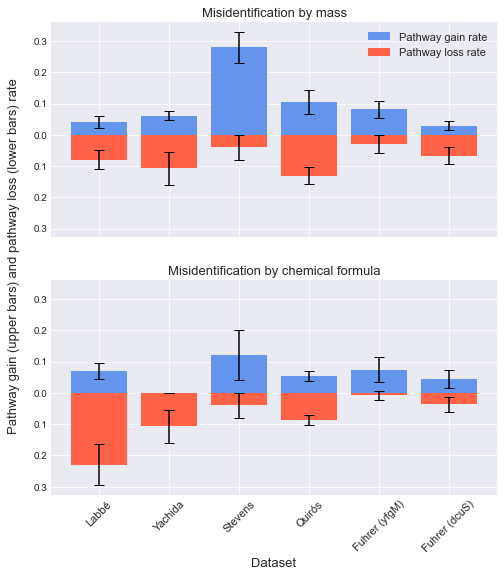

In [4]:
plt.style.use("seaborn-darkgrid")
plt.rc('xtick',labelsize=11)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 9), sharex=True, sharey=True)

ax1.bar(mass_FPR["Dataset"].tolist(), mass_FPR["Average fraction"],
        yerr=mass_FPR["SEM"], capsize=5, label="Pathway gain rate", color="cornflowerblue")
ax1.bar(mass_TPR["Dataset"].tolist(), -mass_TPR["Average fraction"],
        yerr=mass_TPR["SEM"], capsize=5, label="Pathway loss rate", color="tomato")
ax1.set_title("Misidentification by mass", fontsize=13)

ax2.bar(formula_FPR["Dataset"].tolist(), formula_FPR["Average fraction"],
        yerr=formula_FPR["SEM"], capsize=5, label="Pathway gain rate", color="cornflowerblue")
ax2.bar(formula_TPR["Dataset"].tolist(), -formula_TPR["Average fraction"],
        yerr=formula_TPR["SEM"], capsize=5, label="Pathway loss rate", color="tomato")
ax2.set_title("Misidentification by chemical formula", fontsize=13)

ax2.set_xlabel("Dataset", fontsize=13)
fig.text(0.06, 0.25, "Pathway gain (upper bars) and pathway loss (lower bars) rate", fontsize=13, ha='center', rotation="vertical")
ax1.legend(fontsize=11)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    
ticks =  ax1.get_yticks()
ticks2 =  ax2.get_yticks()

# set labels to absolute values and with integer representation
ax1.set_yticklabels([round((abs(x)), 1) for x in ax1.get_yticks()])
plt.gcf().subplots_adjust(bottom=0.15)
# plt.savefig("../Figures/pathway_gain_loss_mass_formula_4_pct_2.png", dpi=600)
plt.show()


<a id='s6'></a>
## Metabolite polarity

In [11]:
from matplotlib_venn import venn2

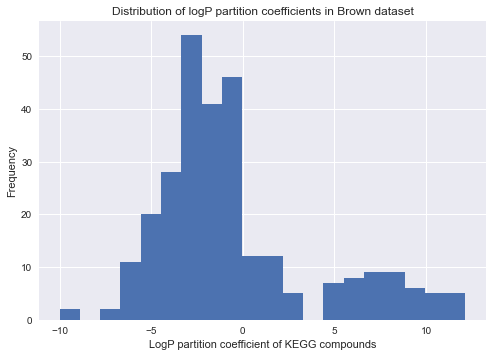

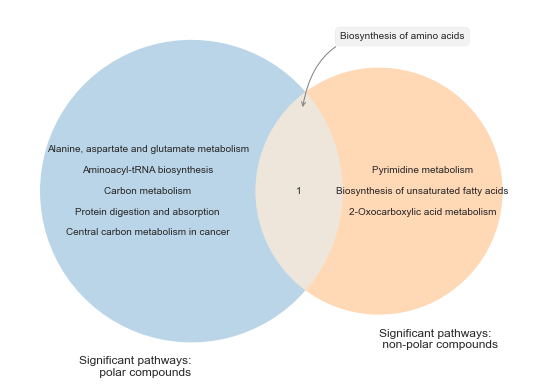

In [12]:
logp_all = pd.read_csv("hmdb_logp_all.csv", index_col=0)

DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)

cols = mat_brown.columns.tolist()
matching_id = logp_all[logp_all["kegg_id"].isin(cols)]
plt.style.use("seaborn")
plt.hist(matching_id["logp"], bins=20)
plt.xlabel("LogP partition coefficient of KEGG compounds")
plt.ylabel("Frequency")
plt.title("Distribution of logP partition coefficients in Brown dataset")
plt.show()

# Brown - split at -1 or -2
def log_p_venn(cutoff, mat, pathways):
    polar = matching_id[matching_id["logp"] < cutoff]
    nonpolar = matching_id[matching_id["logp"] > cutoff]

    polar_mat = mat.filter(polar["kegg_id"])
    polar_mat = polar_mat.iloc[:, ~polar_mat.columns.duplicated()]
    ttest_polar = utils.t_tests(polar_mat, mat["Group"], "fdr_bh")
    dem_polar = ttest_polar[ttest_polar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_polar = utils.over_representation_analysis(dem_polar, polar_mat.columns.tolist(), pathways)

    nonpolar_mat = mat.filter(nonpolar["kegg_id"])
    nonpolar_mat = nonpolar_mat.iloc[:, ~nonpolar_mat.columns.duplicated()]
    ttest_nonpolar = utils.t_tests(nonpolar_mat, mat["Group"], "fdr_bh")
    dem_nonpolar = ttest_nonpolar[ttest_nonpolar["P-adjust"] <= 0.05]["Metabolite"].tolist()
    ora_nonpolar = utils.over_representation_analysis(dem_nonpolar, nonpolar_mat.columns.tolist(), pathways)

    polar_pathways = ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    nonpolar_pathways = ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_ID"].tolist()
    common_paths = list(set(polar_pathways) & set(nonpolar_pathways))

    pp_names = [' '.join(i.split(' ')[:-4]) for i in ora_polar[ora_polar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    np_names = [' '.join(i.split(' ')[:-4]) for i in ora_nonpolar[ora_nonpolar["P-value"] <= 0.1]["Pathway_name"].tolist()]
    common_names = list(set(pp_names) & set(np_names))

    plt.style.use("seaborn")
    venn = venn2(subsets = (set(polar_pathways),
                            set(nonpolar_pathways)), set_labels = ('Significant pathways:\n polar compounds', 'Significant pathways:\n non-polar compounds'),
                 set_colors=('tab:blue', 'tab:orange'), alpha = 0.3)
    venn.get_label_by_id('100').set_text("\n\n".join([i for i in pp_names if i not in common_names]))
    venn.get_label_by_id('010').set_text("\n\n".join([i for i in np_names if i not in common_names]))
    plt.annotate("\n".join(common_names), xy=venn.get_label_by_id('110').get_position() - np.array([-0.01, -0.25]), xytext=(100,70),
    ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray', linewidth=1))

    plt.tight_layout()
    # plt.savefig("../Figures/logp_brown_venn.png", dpi=300)
    plt.show()

log_p_venn(-2, mat_brown, KEGG_mouse_pathways)